# Analyze CGNet Events

## Import libraries

In [2]:
import os
import sys
import numpy as np

sys.path.append("/glade/work/kdagon/ClimateNet") # append path to ClimateNet repo
from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
#from climatenet.analyze_events import analyze_events
from climatenet.analyze_events_region import analyze_events # regionally modified script
#from climatenet.visualize_events import visualize_events
from climatenet.visualize_events_region import visualize_events # regionally modified script

from os import path

In [3]:
import xarray as xr

In [4]:
import dask

In [19]:
import matplotlib.pyplot as plt

## Read in masks
### Notes
* Testing if the track/analyze scripts can be run on non-global spatial extent masks
  * It works, but some of the plotting assumes global extent so needs modification
* dask is not in cgnet environment so created a new env `cgnet-dask` cloned and then added dask
* cgnet scripts use multiprocessing pool so there is some parallelism there
* Could also put in a large mem cpu request on Jhub casper batch if needed (and/or PBSCluster for notebook workers)
* Do I need GPUs to run the analysis scripts? Doesn't look like they use torch

In [5]:
test_2000_file = '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/masks_unwgt/class_masks.nc'

### Set regional bounds

In [6]:
# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds = slice(180,255)

### Preprocessing function to subset regionally

In [7]:
def preprocess_region(ds):
    # return regional domain
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

In [8]:
%%time
test_2000_masks = xr.open_mfdataset(test_2000_file, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 21.5 ms, sys: 45.9 ms, total: 67.4 ms
Wall time: 464 ms


In [9]:
test_2000_masks

<xarray.DataArray 'masks' (time: 2920, lat: 170, lon: 241)>
dask.array<getitem, shape=(2920, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
Attributes:
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc10
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    input_file:                 /glade/campaign/cgd/ccr/jet/nanr_forKatie/3hr...
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    title:                      UNSET
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

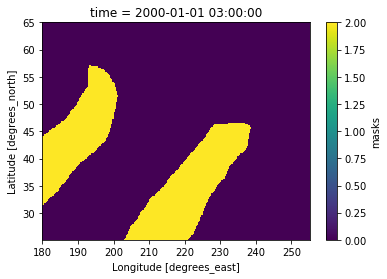

In [11]:
test_2000_masks.isel(time=0).plot();

## Track events
### Notes
* One year of regionally subset data takes ~3min to run `track_events` without PBSCluster on a JHub login node (longer on batch?)

In [10]:
%%time
event_masks = track_events(test_2000_masks) # masks with event IDs

identifying connected components..
tracking components across time..


100%|██████████| 2920/2920 [02:41<00:00, 18.12it/s]


num TCs: 7
num ARs: 92
CPU times: user 2min 42s, sys: 17.3 s, total: 3min
Wall time: 3min 11s


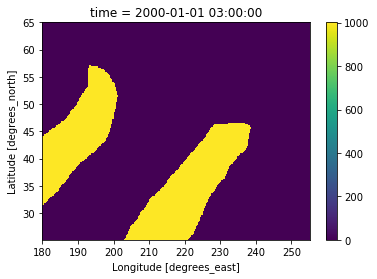

In [15]:
event_masks.isel(time=0).plot();

In [24]:
# these are indexed by time
event_masks.shape

(2920, 170, 241)

## Analyze events

In [12]:
save_dir = '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/masks_unwgt/'

calculating centroids..
extracting event types..
calculating genesis and termination frequencies..
generating histograms..
generating frequency maps..
CPU times: user 13.6 s, sys: 19.6 s, total: 33.2 s
Wall time: 43.4 s


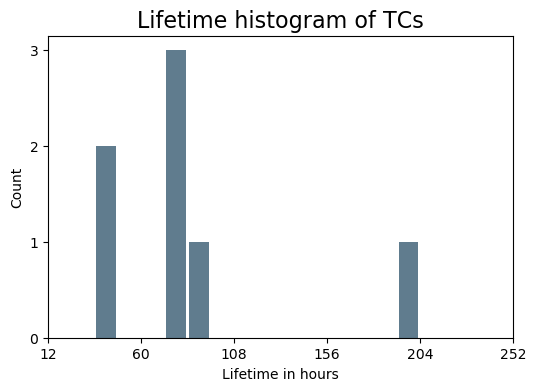

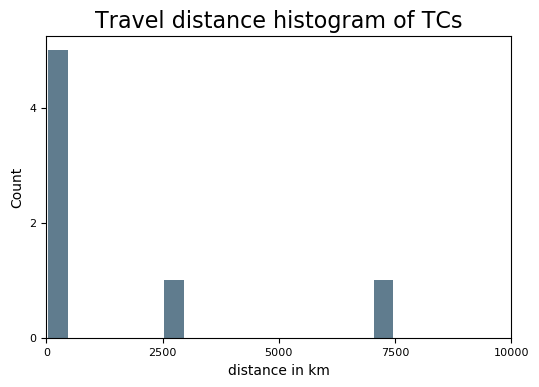

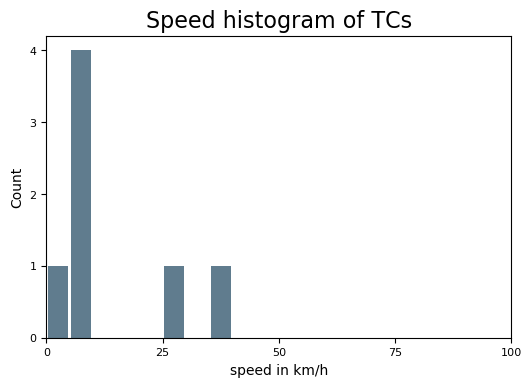

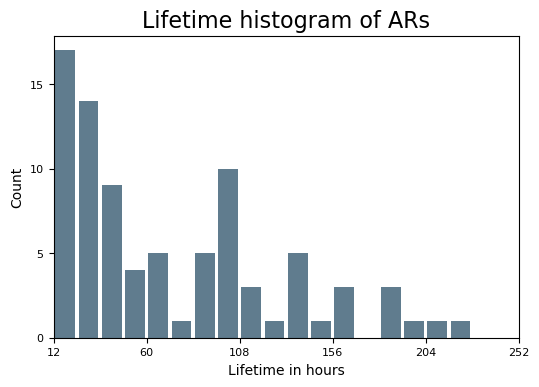

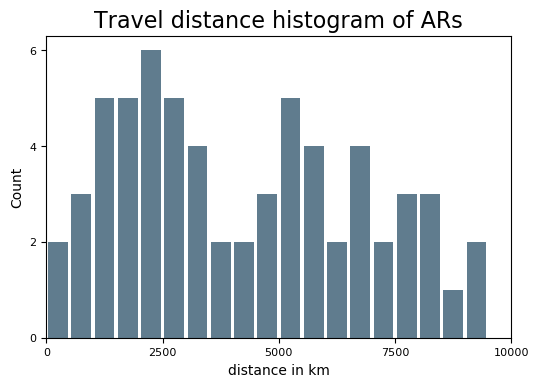

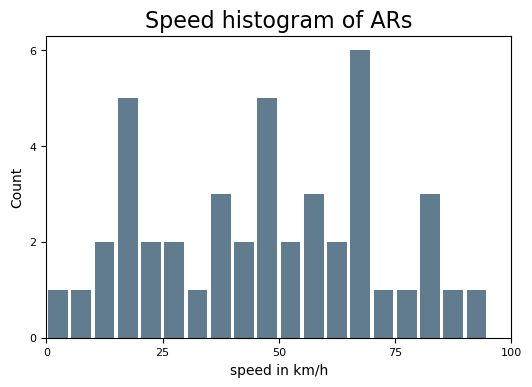

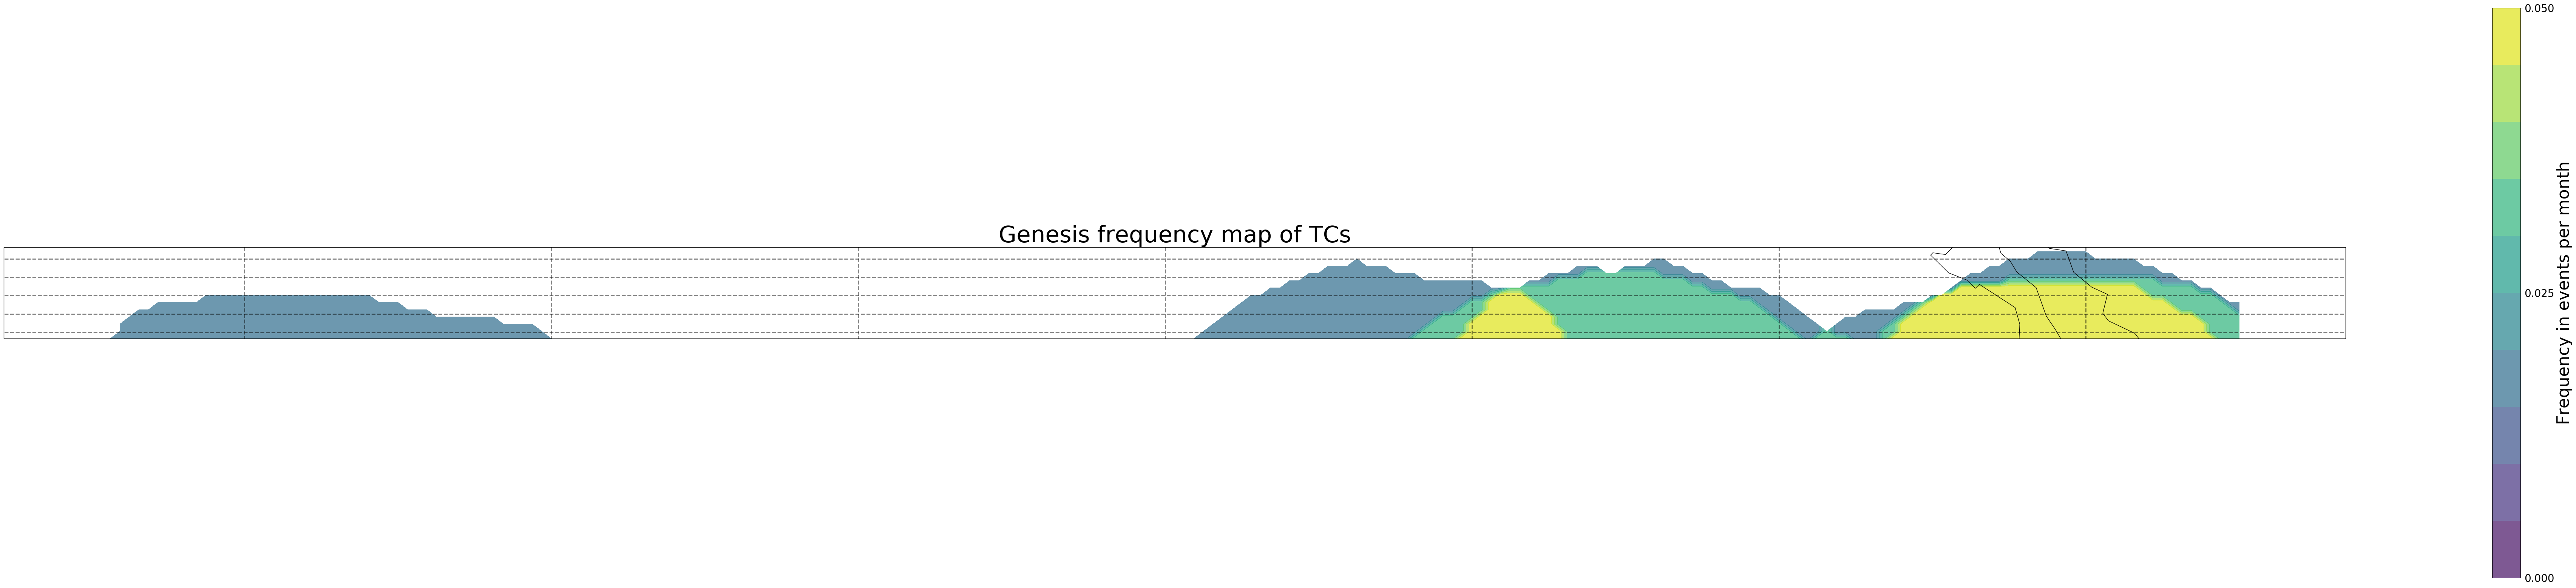

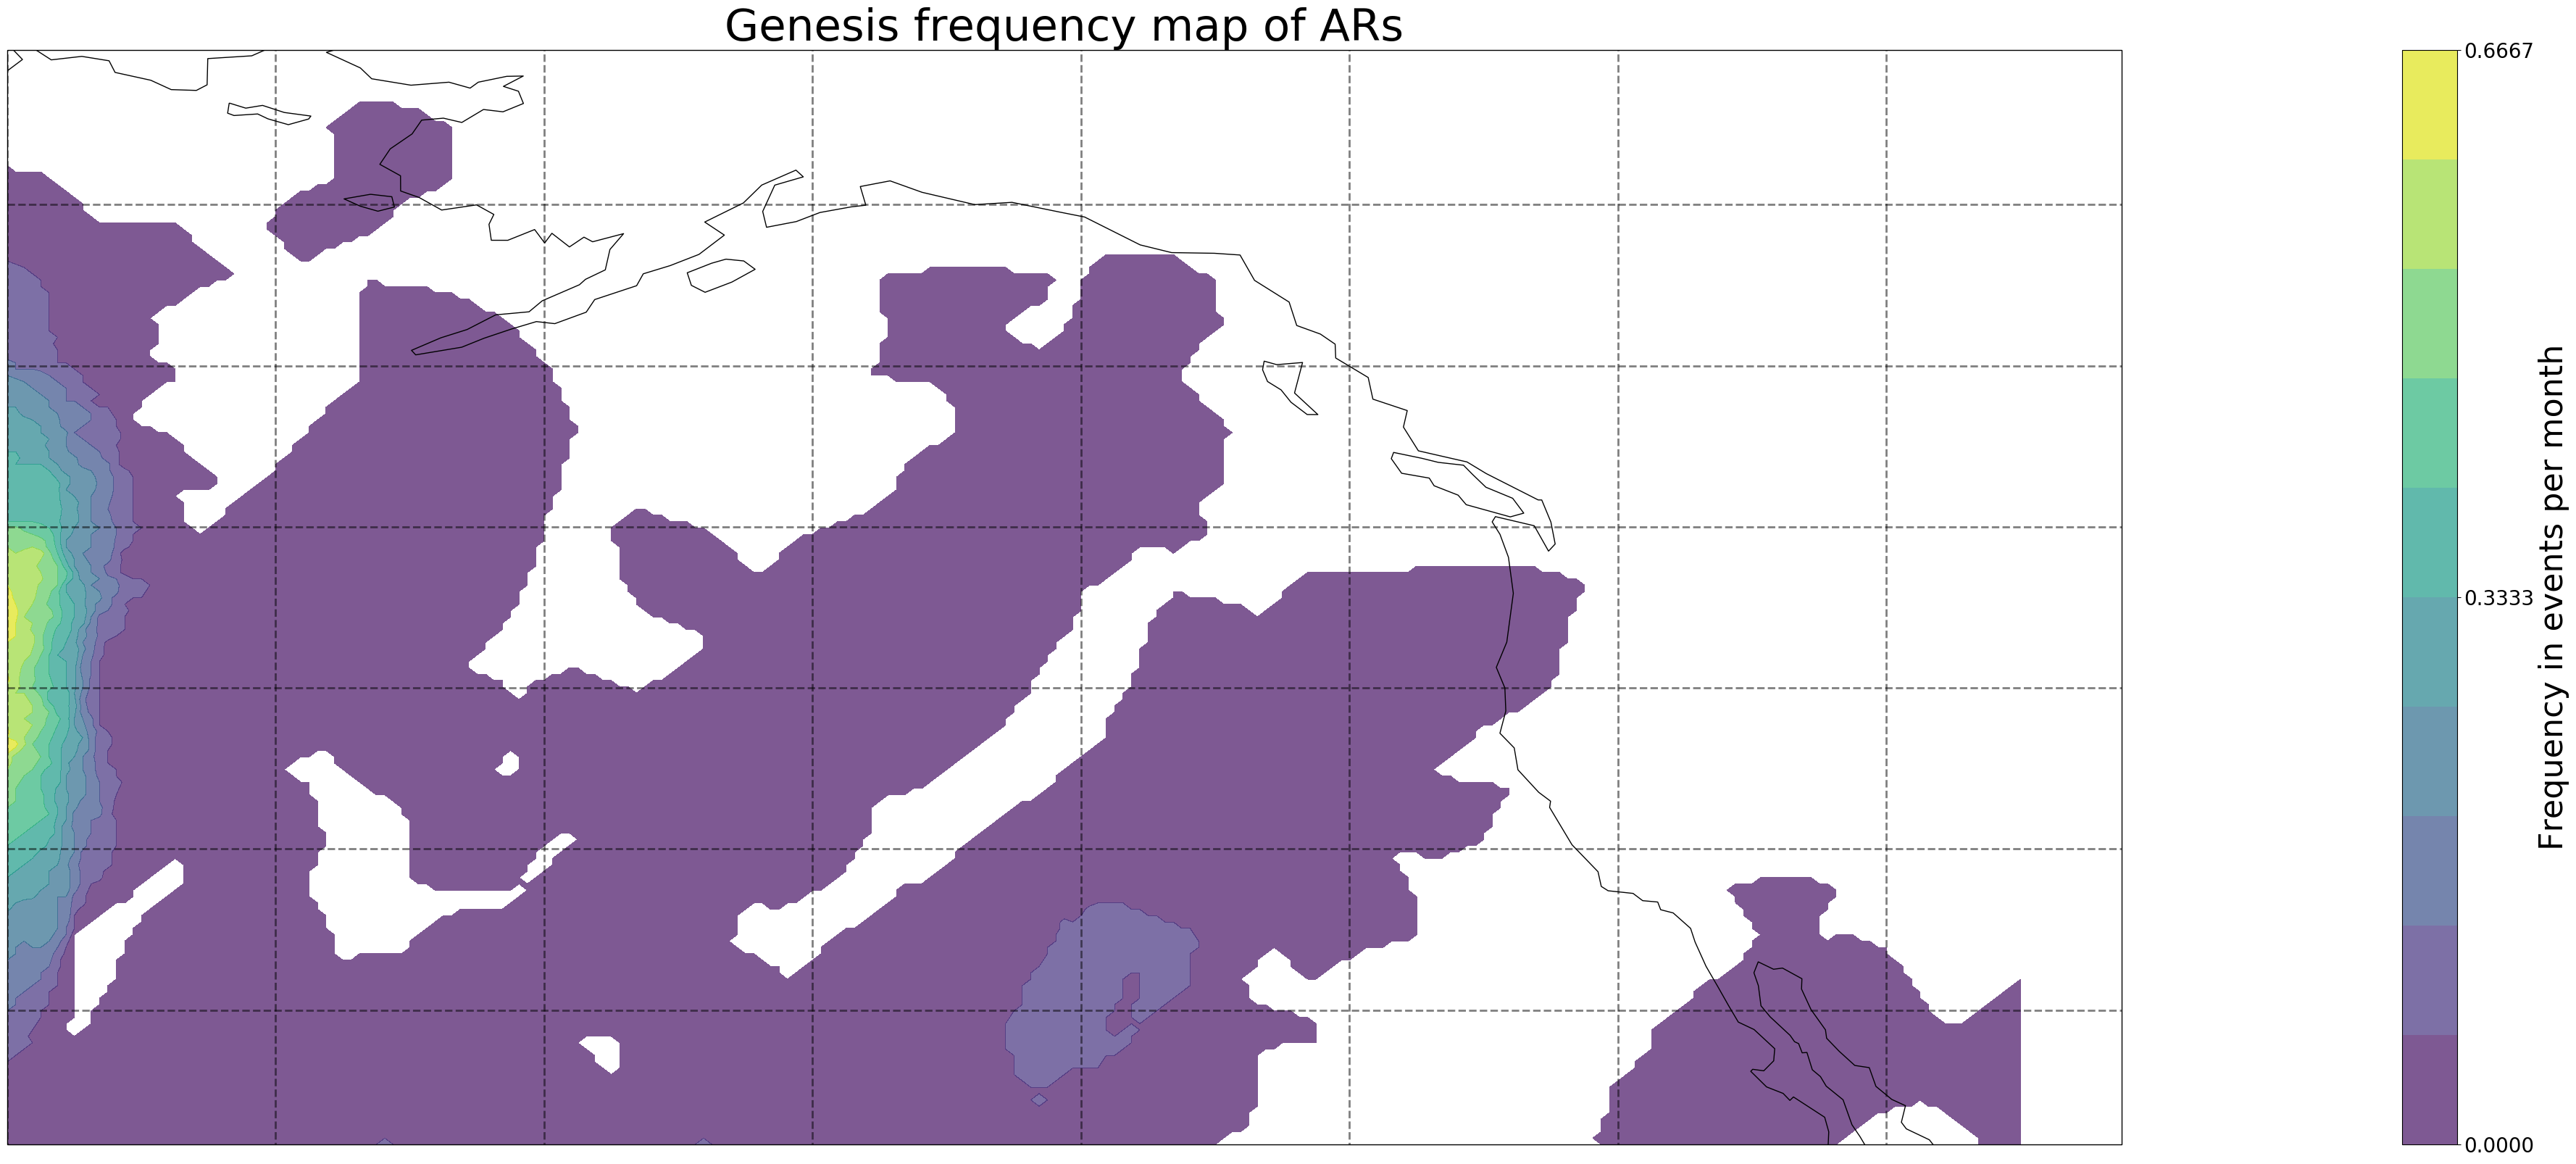

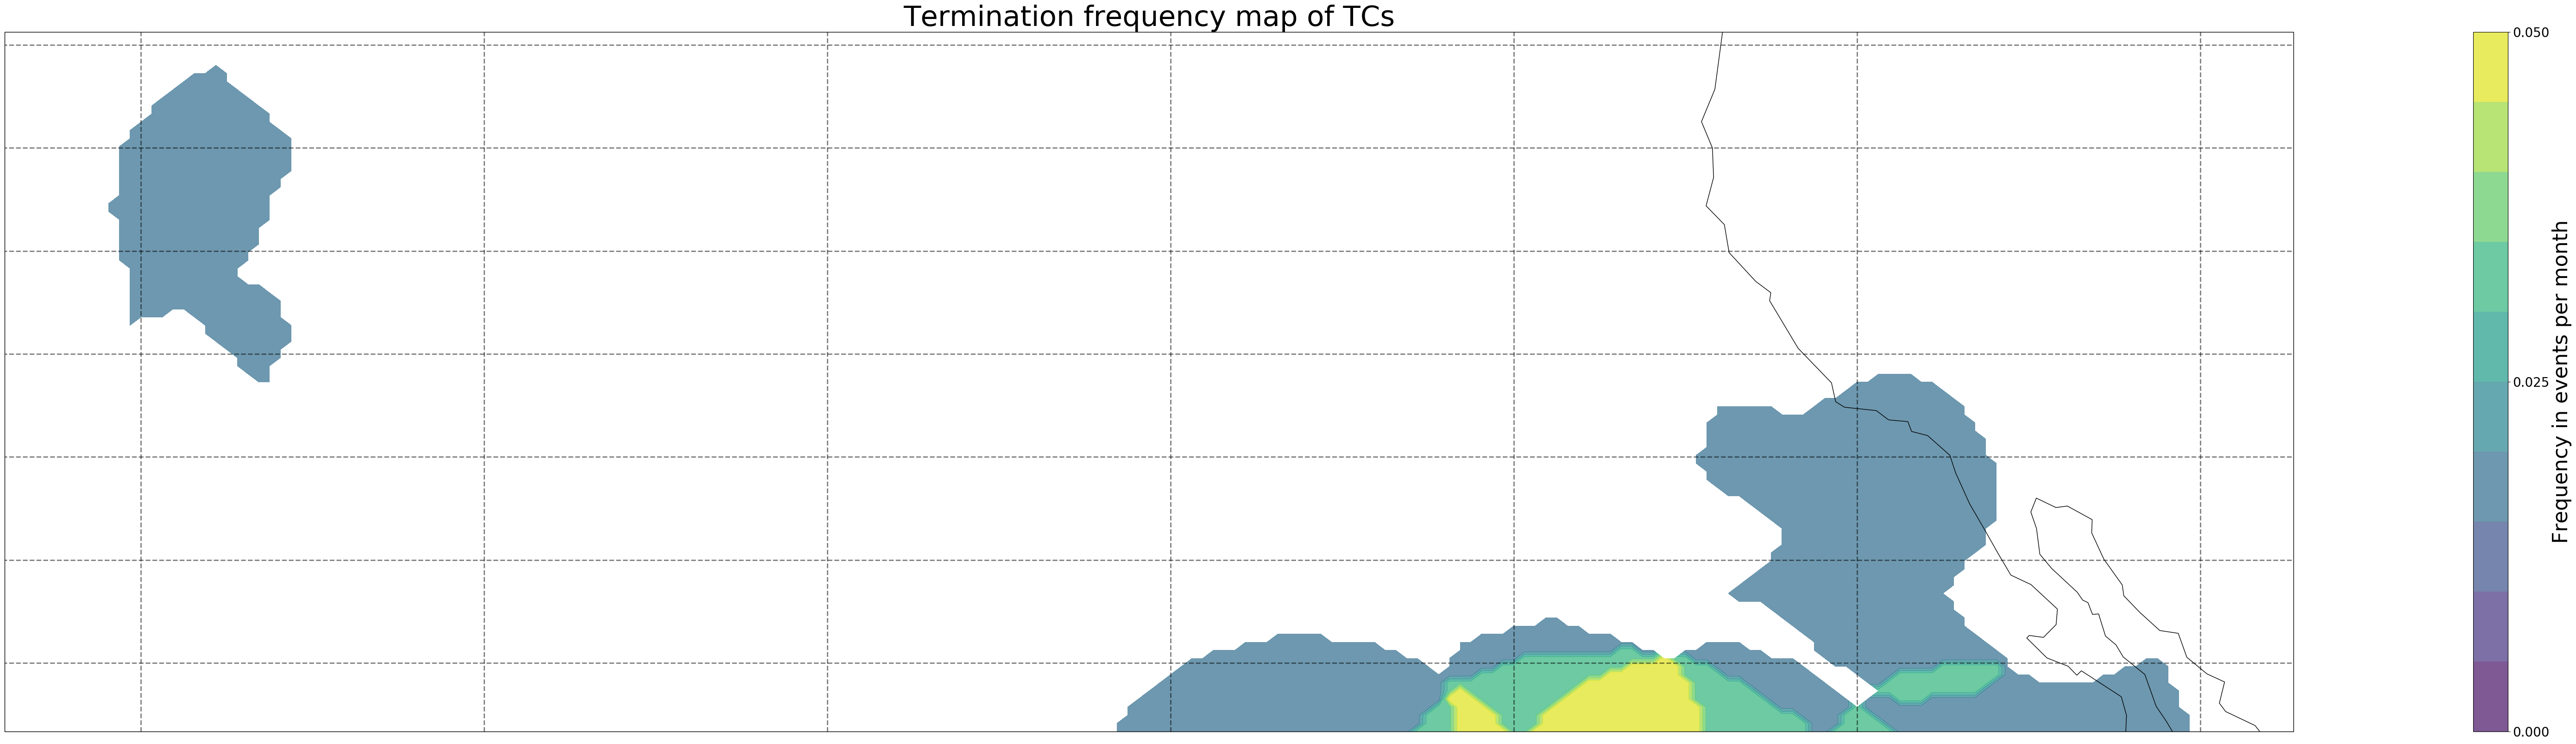

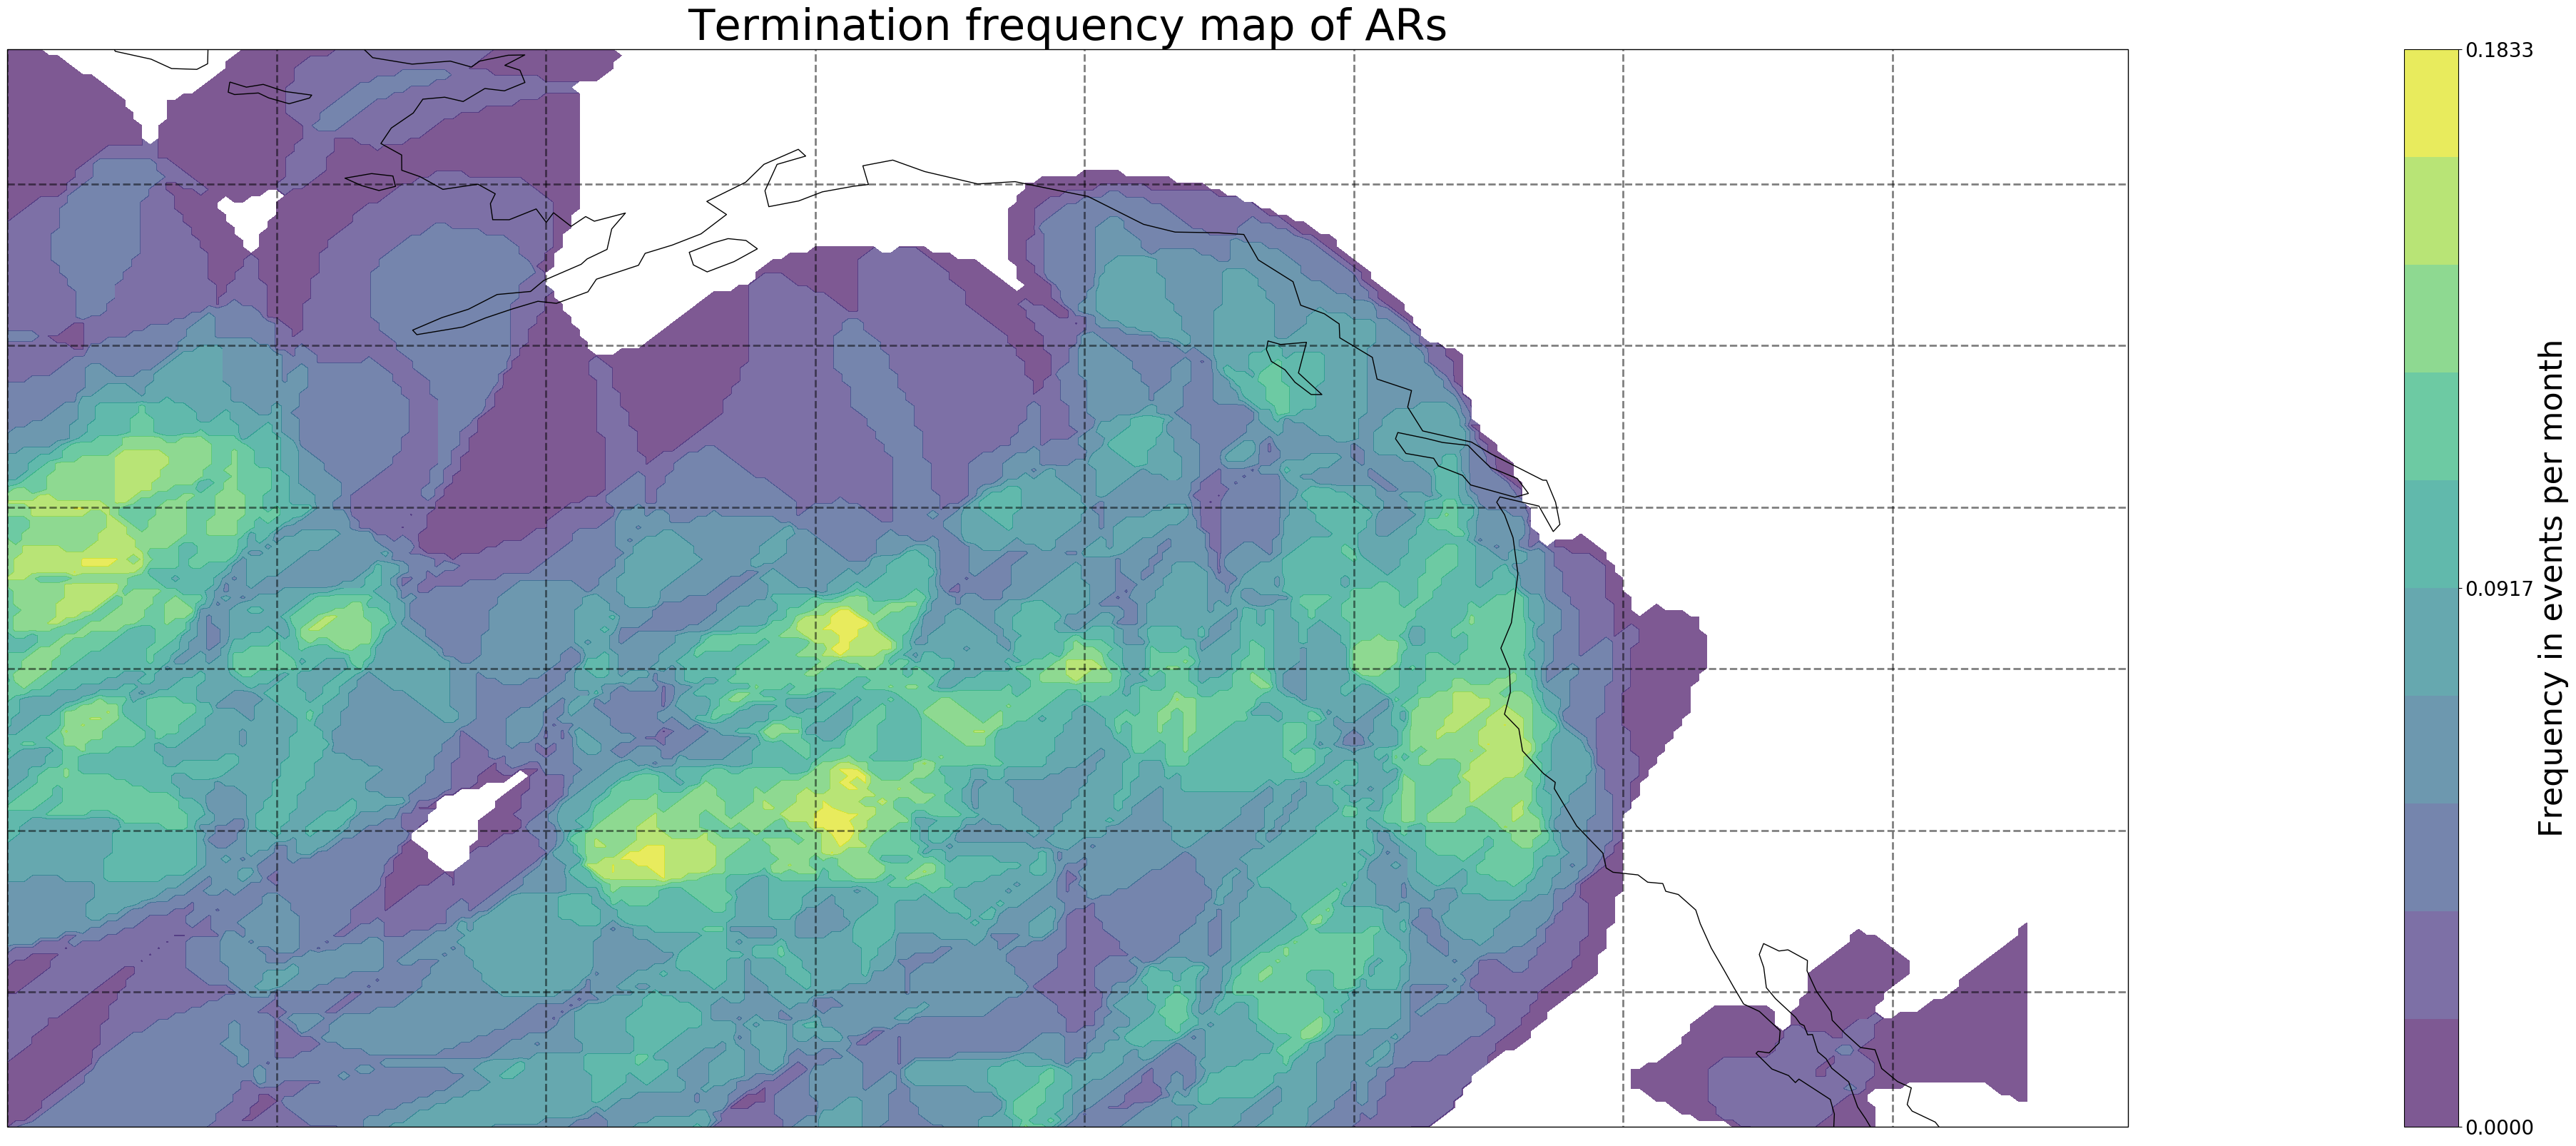

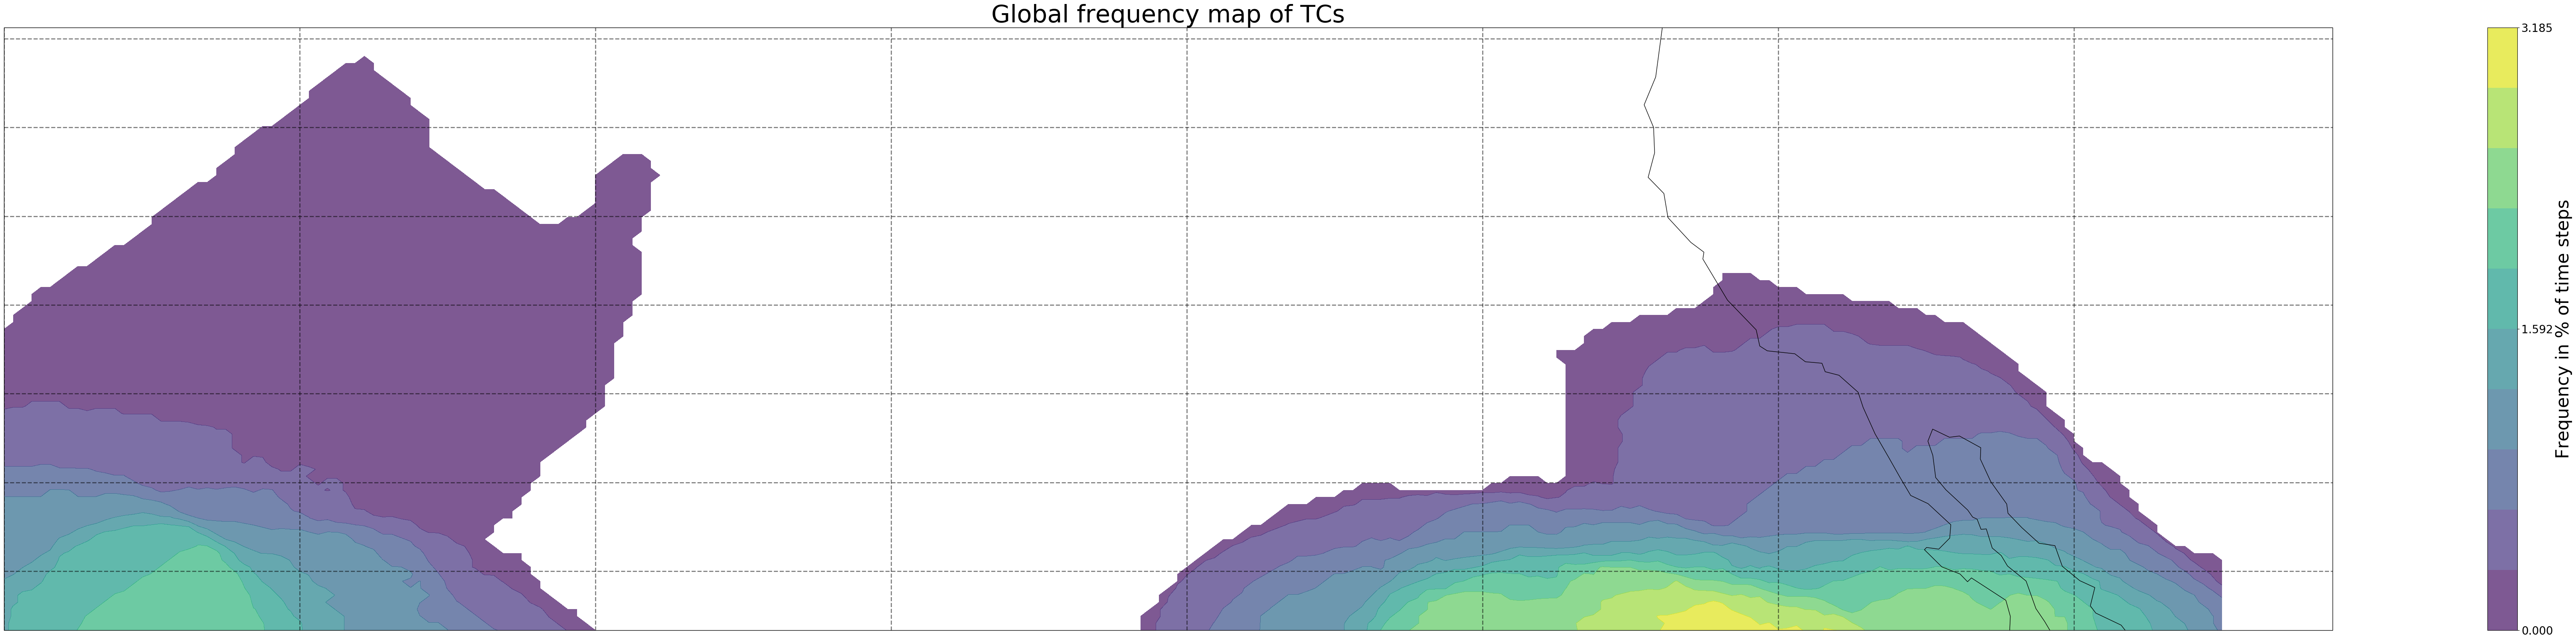

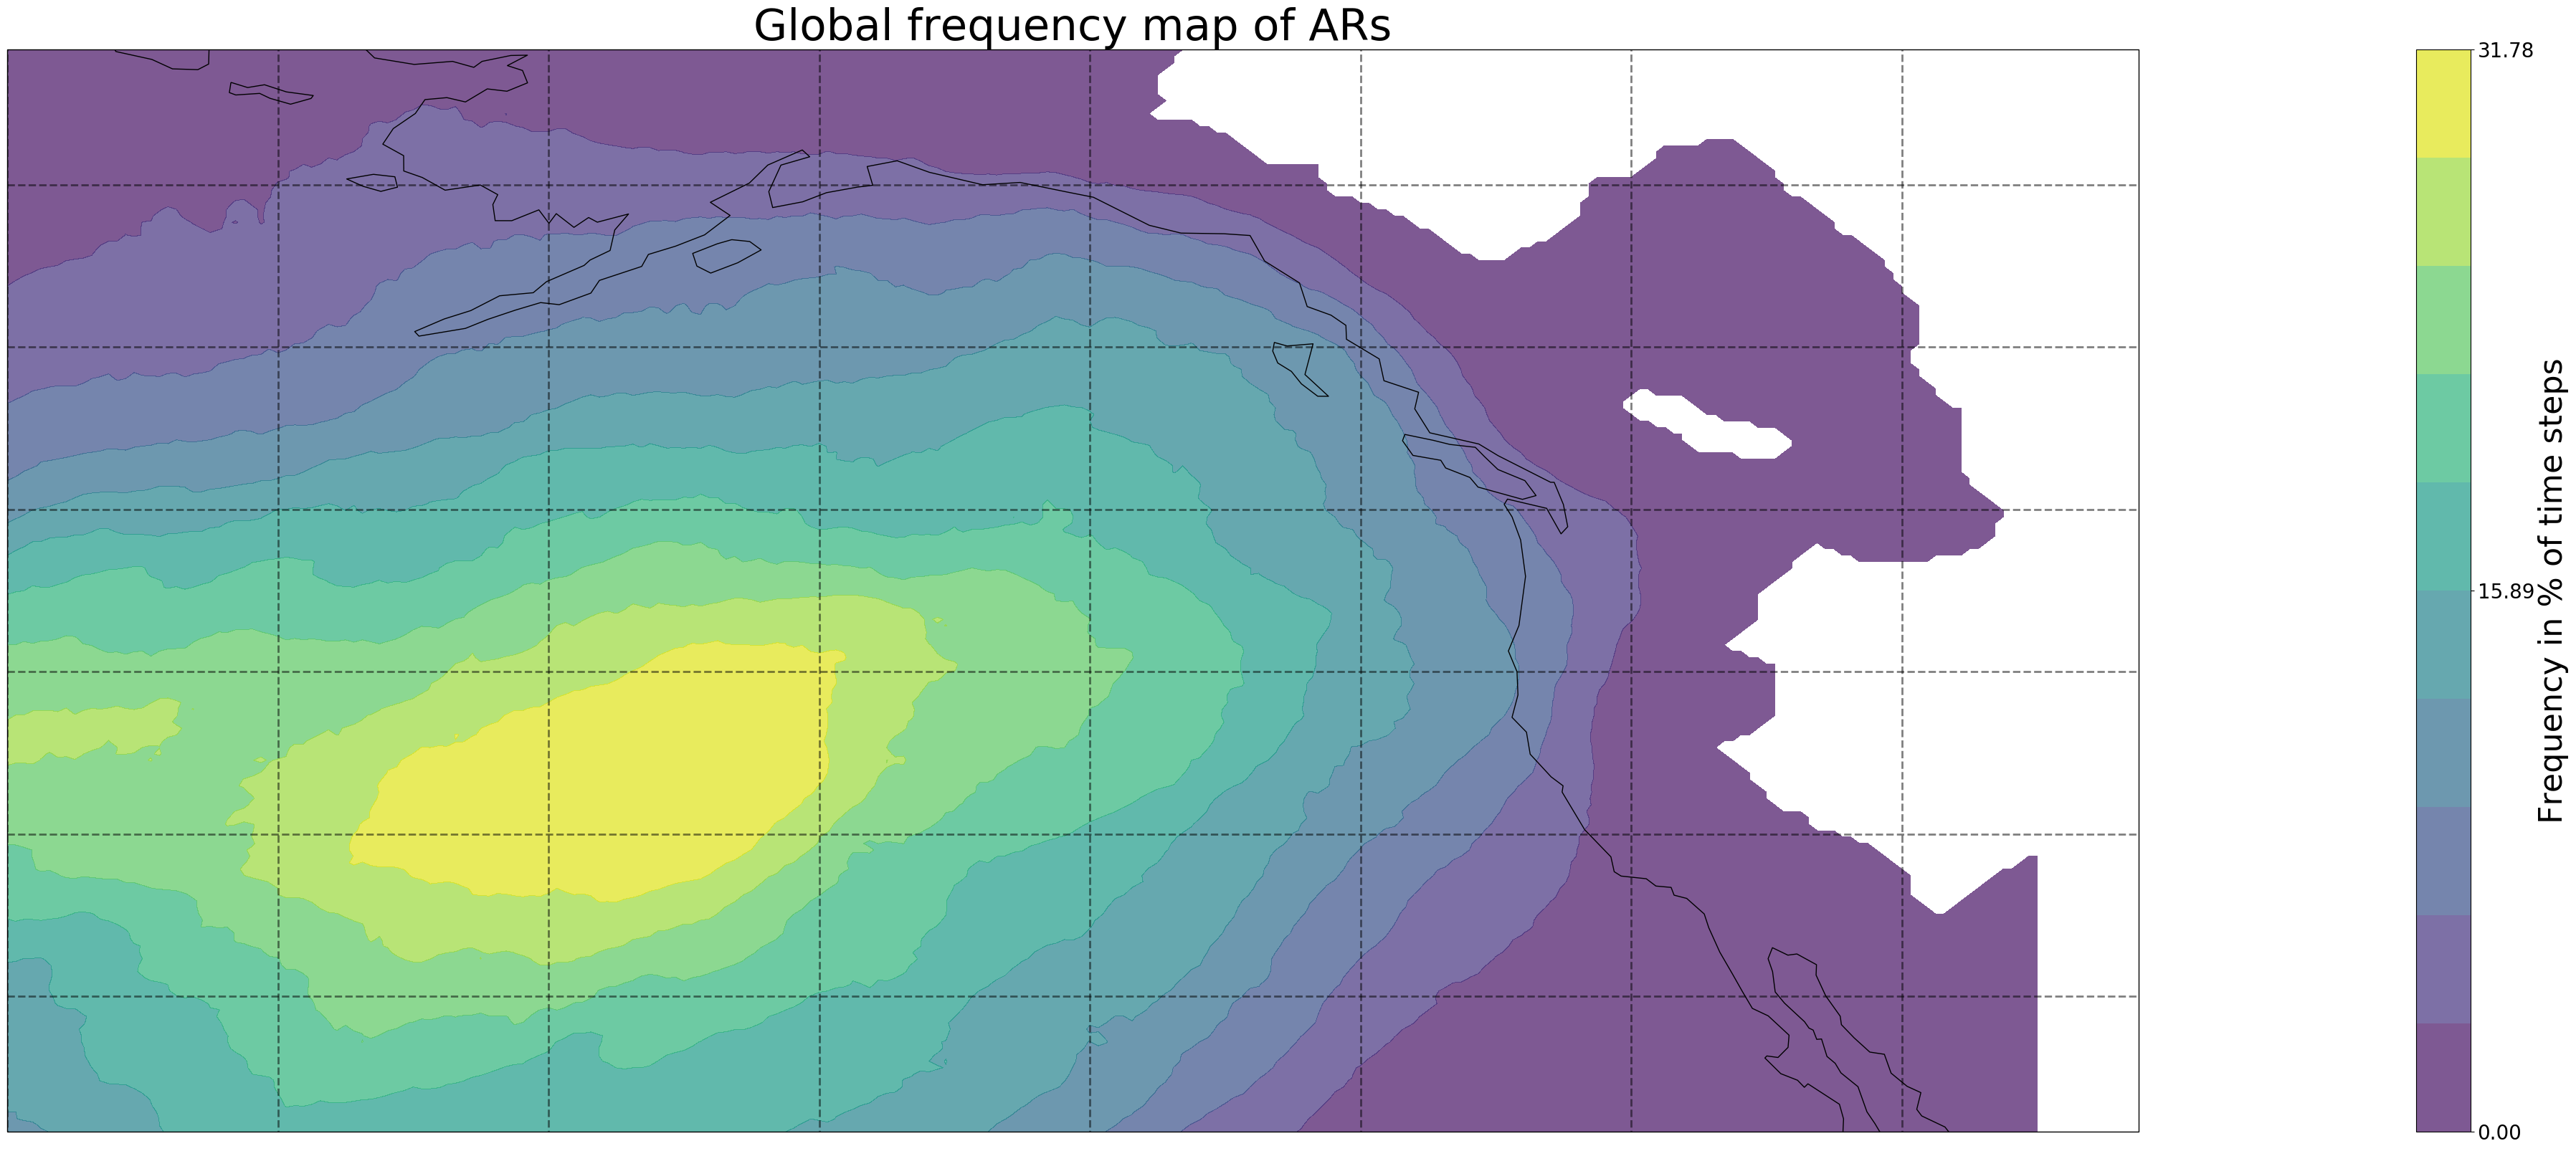

In [13]:
%%time
#analyze_events(event_masks, test_2000_masks, save_dir+'analyze/')
genesis_frequency_ar, genesis_frequency_tc, termination_frequency_ar, termination_frequency_tc = analyze_events(event_masks, test_2000_masks, save_dir+'analyze/')

In [26]:
# these are not indexed by time (freq per month)
genesis_frequency_ar.shape

(170, 241)

In [16]:
genesis_frequency_ar

array([[0.03333333, 0.03333333, 0.03333333, ..., 0.01666667, 0.01666667,
        0.01666667],
       [0.03333333, 0.03333333, 0.03333333, ..., 0.01666667, 0.01666667,
        0.01666667],
       [0.03333333, 0.03333333, 0.03333333, ..., 0.01666667, 0.01666667,
        0.01666667],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### One idea here is to do a larger spatial area for the genesis map to see where these regional ARs are originating

CPU times: user 20.9 ms, sys: 128 µs, total: 21 ms
Wall time: 20.1 ms


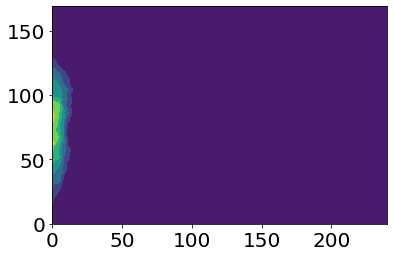

In [21]:
%%time
plt.contourf(genesis_frequency_ar);

### The termination map is more interesting in this region close to the coastline

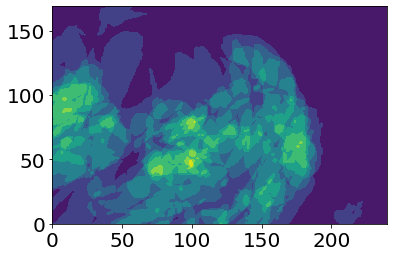

In [22]:
plt.contourf(termination_frequency_ar);

## Visualize events

### This script needs a `ClimateDataset` with TMQ

In [14]:
model_path = '/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.040523' # unweighted means/std in config file
inference_path = '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/' # test year 2000

### Confirm GPU resources
Can request through JupyterHub launch page.\
Current resources request (as of 4/5/23): 1 node, 2 cpu, 64GB mem, 2 V100 GPU

In [11]:
# requires loading pytorch into environment
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
2


In [12]:
# instantiate CGNet with pre-trained model
cgnet = CGNet(model_path=model_path)

In [15]:
# inference using the pre-trained config file
inference = ClimateDataset(inference_path, cgnet.config)

In [19]:
inference.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'U850': {'mean': 1.5530235767364502, 'std': 8.29762077331543},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541},
 'PSL': {'mean': 100814.078125, 'std': 1461.225830078125}}

In [21]:
inference.length

2920

In [29]:
inference[0].sel(variable="TMQ", lat=lat_bounds, lon=lon_bounds)[0]

<xarray.DataArray (lat: 170, lon: 241)>
array([[ 0.32455808,  0.30092496,  0.26880386, ..., -0.9406195 ,
        -0.8912217 , -0.85587865],
       [ 0.27786812,  0.25678587,  0.22858252, ..., -0.90729797,
        -0.8536453 , -0.8300588 ],
       [ 0.2401025 ,  0.21914276,  0.19865936, ..., -0.86855245,
        -0.8197885 , -0.81094086],
       ...,
       [-1.0267847 , -1.0258461 , -1.025046  , ..., -1.1119231 ,
        -1.1130844 , -1.1142647 ],
       [-1.0298895 , -1.0281522 , -1.0272939 , ..., -1.1125365 ,
        -1.1137369 , -1.1149408 ],
       [-1.0399888 , -1.0374137 , -1.0349996 , ..., -1.1133527 ,
        -1.1145583 , -1.1157688 ]], dtype=float32)
Coordinates:
  * lon       (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
    time      object 2000-01-01 03:00:00
  * lat       (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
    variable  <U4 'TMQ'
Attributes:
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc10
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    input_file:                 /glade/campaign/cgd/ccr/jet/nanr_forKatie/3hr...
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    title:                      UNSET
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [34]:
event_masks[0]

<xarray.DataArray (lat: 170, lon: 241)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
    time     object 2000-01-01 03:00:00
Attributes:
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    remap_hostname:             crhtc10
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    input_file:                 /glade/campaign/cgd/ccr/jet/nanr_forKatie/3hr...
    np:                         4
    ne:                         120
    case:                       b.e13.B20TRC5CN.ne120_g16.003
    title:                      UNSET
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

This didn't work - maybe because inference is global and event_masks is not?\
With regional mods did make some pngs but they are wrong...slicing latitudes but not longitudes?

In [30]:
%%time
visualize_events(event_masks, inference, save_dir+'visualize/')

generating images..


/glade/work/kdagon/miniconda/envs/cgnet-dask/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/cgnet-dask/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


IndexError: index 3 is out of bounds for axis 0 with size 1